In [1]:
# autoreload magic to ensure up-to-date code
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm

import numpy as np

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# dataset stuff
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid


# plotting
import matplotlib.pyplot as plt

# model and utils
from model import ContextUnet
from utils import plot, show, extract, save_gif

In [4]:
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

## Different noise schedulers (create betas)

In [5]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

## Create all required variables from $\beta_t$
$1/\sqrt{\alpha_t}$, $\sqrt{\bar{\alpha_t}}$, $\sqrt{1 - \bar{\alpha_t}}$, etc...

In [6]:
def ddpm_schedules(timesteps, schedule="linear"):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    if schedule == "linear":
        betas = linear_beta_schedule(timesteps)
    elif schedule == "cosine":
        betas = cosine_beta_schedule(timesteps)

    alphas = 1 - betas
    log_alpha_t = torch.log(alphas)
    alphas_cumprod = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_recip_alphas = 1 / torch.sqrt(alphas)

    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
    mab_over_sqrtmab_inv = (1 - alphas) / sqrt_one_minus_alphas_cumprod

    return {
        "alphas": alphas,  # \alpha_t
        "sqrt_recip_alphas": sqrt_recip_alphas,  # 1/\sqrt{\alpha_t}
        "alphas_cumprod": alphas_cumprod,  # \bar{\alpha_t}
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,  # \sqrt{\bar{\alpha_t}}
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab_inv": mab_over_sqrtmab_inv,  # beta_t / \sqrt{1 - \bar{\alpha_t}})
    }

## Create linear and cosine DDPM schedules

In [7]:
linear_schedule = ddpm_schedules(400, schedule="linear")
linear_schedule_1000 = ddpm_schedules(1000, schedule="linear")
cosine_schedule = ddpm_schedules(400, schedule="cosine")
cosine_schedule_1000 = ddpm_schedules(1000, schedule="cosine")

## Plot difference in $\bar{\alpha_t}$

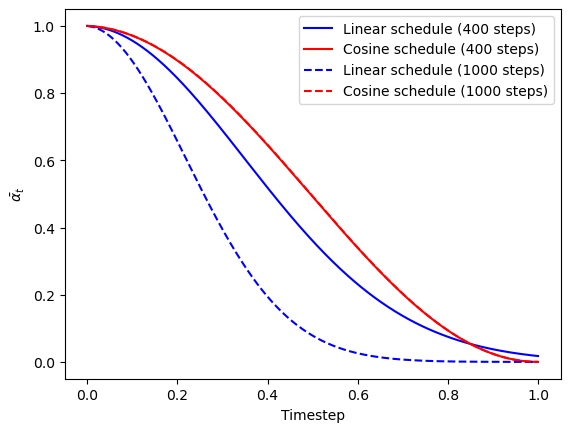

In [8]:
plt.plot(
    np.linspace(0, 1, 400),
    linear_schedule["alphas_cumprod"],
    label="Linear schedule (400 steps)",
    c="b",
)
plt.plot(
    np.linspace(0, 1, 400),
    cosine_schedule["alphas_cumprod"],
    label="Cosine schedule (400 steps)",
    c="r",
)
plt.plot(
    np.linspace(0, 1, 1000),
    linear_schedule_1000["alphas_cumprod"],
    label="Linear schedule (1000 steps)",
    c="b",
    linestyle="--",
)
plt.plot(
    np.linspace(0, 1, 1000),
    cosine_schedule_1000["alphas_cumprod"],
    label="Cosine schedule (1000 steps)",
    c="r",
    linestyle="--",
)
plt.xlabel("Timestep")
plt.ylabel("$\\bar{\\alpha_t}$")
plt.legend()
plt.show()

## Add noise - sample $x_t$ from $\mathcal{N}(\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})I$

In [9]:
def q_sample(schedule, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(schedule["sqrt_alphas_cumprod"], t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        schedule["sqrt_one_minus_alphas_cumprod"], t, x_start.shape
    )

    return (
        sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise,
        noise,
    )

In [10]:
images = torch.stack([dataset[i][0] for i in range(5)], dim=0)

In [11]:
tmp = [images] + [
    q_sample(linear_schedule, images, torch.tensor([t for _ in range(5)]))[0]
    for t in [0, 50, 100, 150, 199]
]

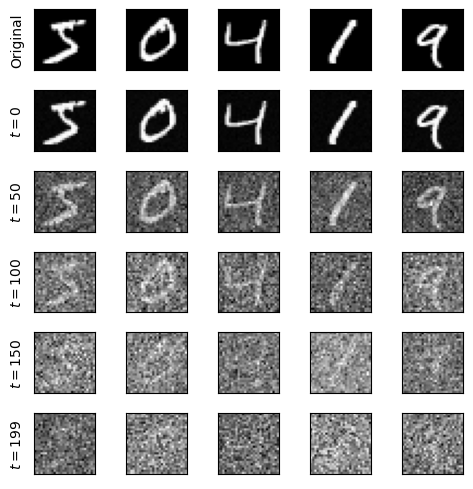

In [12]:
plot(
    [el.permute(0, 2, 3, 1) for el in tmp],
    cmap="gray",
    figsize=(5, 5),
    row_title=["Original", "$t=0$", "$t=50$", "$t=100$", "$t=150$", "$t=199$"],
)

## Nosing process

In [14]:
def noise_image(image_0, schedule, timesteps=400):
    noises = []
    images = []
    for t in range(1, timesteps + 1):
        image, noise = q_sample(schedule, image_0, torch.tensor([t]))
        noises.append(noise)
        images.append(image)
    return images, noises

In [15]:
image_0 = dataset[0][0]

In [16]:
linear_noise_images, linear_noises = noise_image(
    image_0, linear_schedule, timesteps=399
)
cosine_noise_images, cosine_noises = noise_image(
    image_0, cosine_schedule, timesteps=399
)

In [152]:
linear_grid = make_grid(linear_noise_images, nrow=40, padding=1, normalize=True)
cosine_grid = make_grid(cosine_noise_images, nrow=40, padding=1, normalize=True)

In [151]:
# show(linear_grid, figsize=(25, 10))
# show(cosine_grid, figsize=(25, 10))

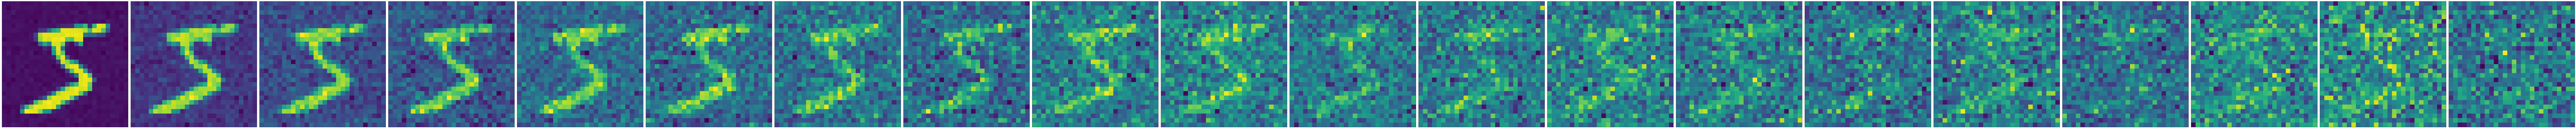

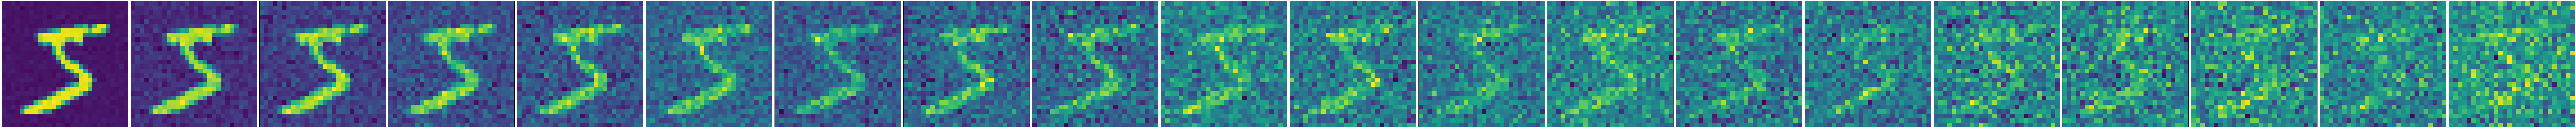

In [150]:
plot([el.permute(1, 2, 0) for el in linear_noise_images[:200:10]])
plot([el.permute(1, 2, 0) for el in cosine_noise_images[:200:10]])

## We want to train our model based on the condition (class)

We will do it in Classifier-Free guidance style\
For this we need a conditioned model (basically UNet)

With class: $\epsilon_\theta(x_t, c)$\
Without class: $\epsilon_\theta(x_t, c=0)$

#### Training is similar to regular DDPM model, but we drop class information with some probability

1. Get $x_0$ and $c$ from dataset
2. Randomly discard class labels $c$ with probability $p$
3. Sample $\epsilon$ from $\mathcal{N}(0, I)$
2. Get $x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{(1-\bar{\alpha_t})}\epsilon$
4. Calculate $\epsilon_\theta(x_t, c)$
5. Take gradient step on $\nabla_{\theta}||\epsilon_\theta(x_t, c) - \epsilon||^2$

#### Sampling loop is similar to DDPM loop except we use weighted combination of predicted noise with and without class

$\tilde{\epsilon}_\theta(x_t, c) = (1 + w) \epsilon_\theta(x_t, c) - w \epsilon_\theta(x_t, c=0)$

- When $w=0$, the model is a normal DDPM with class information.
- When $w>0$, we utilize classifier-free guidance. The goal is to produce an image of class $c$.

The idea is that the class-informed model will generate an output about the class we want to generate, but the class signal could be stronger.\
To strengthen the signal from the class information, we can remove the signal from the model without class information (which should generate a random image).\
As $w$ increases, we are removing more “null” images. Theoretically, the more information we remove with the null class, the more information we will have of the desired class.

## DDPM model

In [63]:
class DDPM(nn.Module):
    def __init__(self, nn_model, timesteps, device, drop_prob=0.1, schedule="linear"):
        super().__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(timesteps + 1, schedule=schedule).items():
            self.register_buffer(k, v)

        self.timesteps = timesteps
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.timesteps + 1, (x.shape[0],)).to(
            self.device
        )  # t ~ Uniform(0, timesteps)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            extract(self.sqrt_alphas_cumprod, _ts, x.shape) * x
            + extract(self.sqrt_one_minus_alphas_cumprod, _ts, x.shape) * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(
            self.device
        )

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(
            noise,
            self.nn_model(
                x_t, c, (_ts.float() / self.timesteps).unsqueeze(-1), context_mask
            ),
        )

    def sample(self, n_sample, size, device, guide_w=0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(
            device
        )  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0, 10).to(
            device
        )  # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample / c_i.shape[0]))
        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1.0  # makes second half of batch context free

        x_i_store = []  # keep track of generated steps in case want to plot something
        print()
        for i in tqdm(range(self.timesteps, 0, -1)):
            t_is = torch.tensor([i]).to(device).long().repeat((n_sample,))

            # Extract all varaibles for denosing
            betas_t = 1 - extract(self.alphas, t_is, x_i.shape)
            sqrt_recip_alphas_t = extract(self.sqrt_recip_alphas, t_is, x_i.shape)
            mab_over_sqrtmab_inv = extract(self.mab_over_sqrtmab_inv, t_is, x_i.shape)

            # Double batch
            x_i = x_i.repeat(2, 1, 1, 1)
            t_is = t_is.repeat(2, 1, 1, 1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # Split predictions and compute weighting
            eps = self.nn_model(
                x_i, c_i, (t_is.float() / self.timesteps).unsqueeze(-1), context_mask
            )
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]

            # Denoise sample
            x_i = (
                sqrt_recip_alphas_t * (x_i - eps * mab_over_sqrtmab_inv)
                + torch.sqrt(betas_t) * z
            )
            if i % 20 == 0 or i == self.timesteps or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

## Training loop

In [35]:
def train_mnist(
    ddpm,
    dataloader,
    n_epoch=10,
    device="cuda:0",
    n_classes=10,
    lrate=1e-4,
    save_model=True,
):

    # hardcoding these here
    save_dir = "./data/"
    ws_test = [0.0, 0.5, 2.0]  # strength of generative guidance

    # Transfer to device

    ddpm.to(device)

    # optionally load a model
    # ddpm.load_state_dict(torch.load("./data/model_1.pth"))

    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f"epoch {ep}")
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]["lr"] = lrate * (1 - ep / n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4 * n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(
                    n_sample, (1, 28, 28), device, guide_w=w
                )

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample / n_classes)):
                        try:
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k + (j * n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all * -1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print("saved image at " + save_dir + f"image_ep{ep}_w{w}.png")

                if ep % 5 == 0 or ep == int(n_epoch - 1):
                    # create gif of images evolving over time, based on x_gen_store
                    save_gif(n_sample, n_classes, x_gen_store, save_dir, ep, w)
        # optionally save model
        if save_model:
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print("saved model at " + save_dir + f"model_{ep}.pth")
    return ddpm

In [36]:
n_feat = 128
device = "mps" # or cuda:0 or cpu
timesteps = 400
batch_size = 256
n_classes = 10

In [64]:
ddpm = DDPM(
    nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes),
    timesteps=timesteps,
    device=device,
    drop_prob=0.1,
    schedule="linear",
)

In [38]:
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
ddpm_model = train_mnist(ddpm, dataloader=dataloader, n_epoch=10, device=device)

#### Results (epoch 0)

- Epoch 0, $w = 0.0$\
    ![](pics/gif_ep0_w0.0.gif)
- Epoch 0, $w = 0.5$\
    ![](pics/gif_ep0_w0.5.gif)
- Epoch 0, $w = 2.0$\
    ![](pics/gif_ep0_w2.0.gif)

#### Results (epoch 3)

- Epoch 3 $w = 0.0$\
    ![](pics/gif_ep3_w0.0.gif)
- Epoch 3, $w = 0.5$\
    ![](pics/gif_ep3_w0.5.gif)
- Epoch 3, $w = 2.0$\
    ![](pics/gif_ep3_w2.0.gif)

#### Evaluation

In [153]:
ddpm.load_state_dict(torch.load("./data/model_9.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

In [118]:
n_sample = 20

In [119]:
ddpm.to(device);

In [120]:
ddpm.eval();

In [121]:
x_gens = []
ws = [0.0, 0.5, 2.0, 4, 10]
with torch.no_grad():
    for i, w in enumerate(ws):
        x_gen, _ = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)
        x_gens.append(x_gen.cpu().detach())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       device='mps:0')



100%|██████████| 400/400 [00:18<00:00, 21.07it/s]


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       device='mps:0')



100%|██████████| 400/400 [00:18<00:00, 21.86it/s]


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       device='mps:0')



100%|██████████| 400/400 [00:17<00:00, 22.22it/s]


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       device='mps:0')



100%|██████████| 400/400 [00:18<00:00, 21.53it/s]


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       device='mps:0')



100%|██████████| 400/400 [00:17<00:00, 22.23it/s]


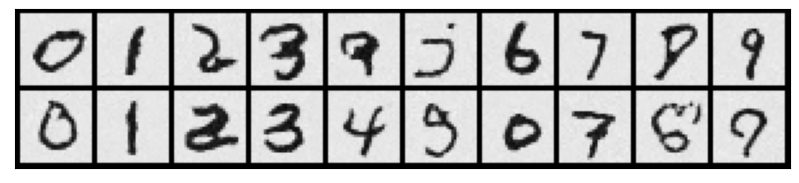

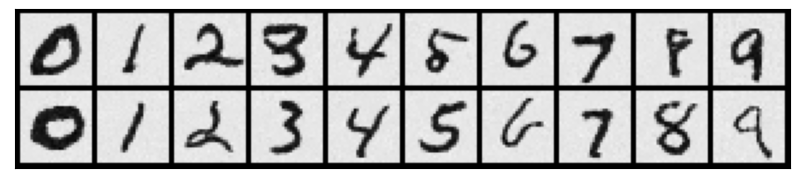

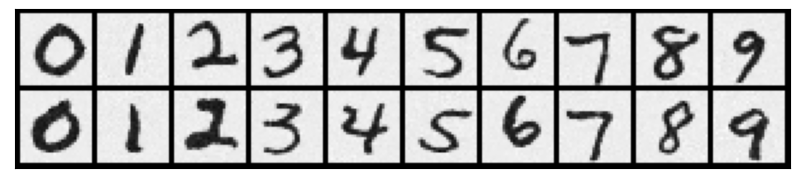

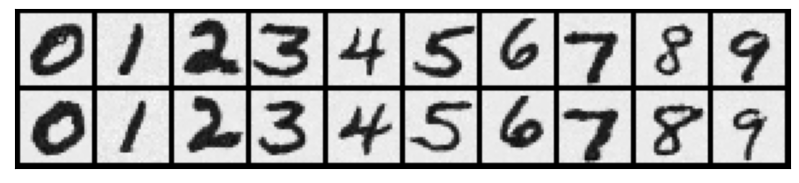

In [90]:
for el in x_gens:
    show(make_grid(el.cpu().detach() * -1 + 1, nrow=10, normalize=True))